# About

Notebook for visualizing LuminarSeq's features and inner workings.

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import torch
import gc

from IPython.display import display, HTML
from luminar.detector import LuminarSequenceDetector
from luminar.utils.cuda import get_best_device
from luminar.sequence_classifier import LuminarSequence
from luminar.utils import LuminarSequenceTrainingConfig, ConvolutionalLayerSpec
from luminar.utils.visualization import visualize_detection

torch.cuda.empty_cache()
gc.collect()
if torch.cuda.is_available():
    with torch.cuda.device(torch.cuda.current_device()):
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

In [31]:
class Config:
    # MODEL_PATH = "/storage/projects/boenisch/PrismAI/models/luminar_sequence/de___en/trvaaa3c" # falcon
    MODEL_PATH = "/storage/projects/boenisch/PrismAI/models/luminar_sequence/PrismAI_v2-encoded-gpt2/e1s2k2du"  # gpt2

In [32]:
detector = LuminarSequenceDetector(model_path=Config.MODEL_PATH, feature_agent="gpt2", device=get_best_device())

Loading LuminarSequenceDetector from /storage/projects/boenisch/PrismAI/models/luminar_sequence/PrismAI_v2-encoded-gpt2/e1s2k2du to device cuda:3
LuminarSequenceTrainingConfig(feature_len=512, num_intermediate_likelihoods=13, apply_delta_augmentation=False, apply_product_augmentation=True, conv_layer_shapes=[[64, 5, 1], [128, 5, 1], [64, 3, 1]], projection_dim=64, lstm_hidden_dim=128, lstm_layers=1, stack_spans=4, hf_dataset='TheItCrOw/PrismAI_v2-encoded-gpt2', dataset_root_path='/storage/projects/stoeckel/prismai/encoded/fulltext/', models_root_path='/storage/projects/boenisch/PrismAI/models/luminar_sequence/', domain=None, agent='gpt_4o_mini_gemma2_9b', feature_agent='gpt2', max_epochs=100, batch_size=128, early_stopping_patience=8, rescale_features=False, kfold=3, learning_rate=0.004, seed=42)
Loaded.


[nltk_data] Downloading package punkt to
[nltk_data]     /home/staff_homes/kboenisc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [33]:
# 5603f122-24ed-4629-bbfd-a2db40f52954
human_document = """
Just think being in a curfew on adoction, just becauses we are on trouble,think about it, sometimes we teenagers we are who has more troubles because of our friends dependen what kind of friends tha we have they may be good friends also bad friends, but think there are people who wants tha all teenager become a good person,they are people who wants you to become a professional. The city is debating the adoction,because they also wants that the teenagers had less troubles, so they can have a family that the can help to advice what is good and bad. The council it may help the teenagers to be more safely, and being out of many bad things, the council the only thing the it wants to do is find a family, and being more happy, and the family can help the anyone being out of troubles. I think the being adocted by the age of a teenagers it can be really hard ,for they and the mew parents, i think the because we all teenager we already know many things bad or we know things good, but also having new parents they may wants us do new things, that maybe that are gonna help us in the future, but we don"t know. Youngers teenagers the only things the we need are parents who are there talking with us, I thing the it will be fine for many teenagers being adocted bye a family because he can knew new life, out of many troubles, and also it wiil be fine being out of bad band.
"""

In [34]:
# 8f208ea3-fccc-477d-a05b-97e4ddcb2a8d
ai_document = """
Adoption, man, it’s like, not just for babies or little kids. Think about us teenagers, right? We go through so much stuff, like with school pressure, figuring out who we are, and all that drama with friends influencing us in all kinds of ways. It’s like, at this age, having a stable family can really change things up for us. Seriously, friends are huge, they can totally make or break your vibe. One day they’re all chill, and the next, they might be pushing you to do stuff that’s way out of line. It’s kinda scary how much they can sway what you do. But that’s where, like, having a solid family setup comes into play. Whether it’s your birth fam or an adoptive one, it matters, dude. They ground you, give you that base to come back to when things get wacky. And it’s not just about having any family, but one that really gets you. One that’s there for you when things get tough, listens to you, and like, supports you to be the best version of yourself. That’s the real game changer. Communities should totally step up, too. More programs, more support groups, stuff like that to help teens navigate through this jungle of growing up. Adopting a teen isn’t just giving them a home, it’s giving them a chance, you know? A chance to reset, to find that support that maybe they’ve never had. It’s about making them feel wanted, valued, like they actually matter. So yeah, adoption can be this huge, positive bomb in a teen’s life, exploding with all the good stuff they need.
"""

In [35]:
ai_result = detector.detect(ai_document)
ai_features = detector.features
print(ai_features.shape)
HTML(visualize_detection(ai_document, ai_result))

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


torch.Size([1, 115, 13])


In [36]:
hu_result = detector.detect(human_document)
hu_features = detector.features
print(hu_features.shape)
HTML(visualize_detection(human_document, hu_result))

torch.Size([1, 49, 13])


In [37]:
X_ai     = ai_features[0].cpu().numpy() 
X_human  = hu_features[0].cpu().numpy() 

tokens_ai   = None
tokens_human= None


## Visualizations

In [38]:
import numpy as np, matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white"
})


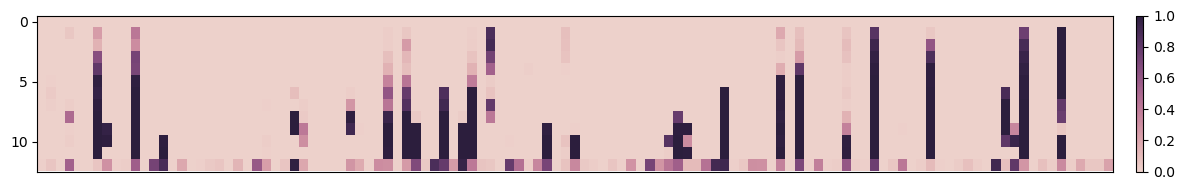

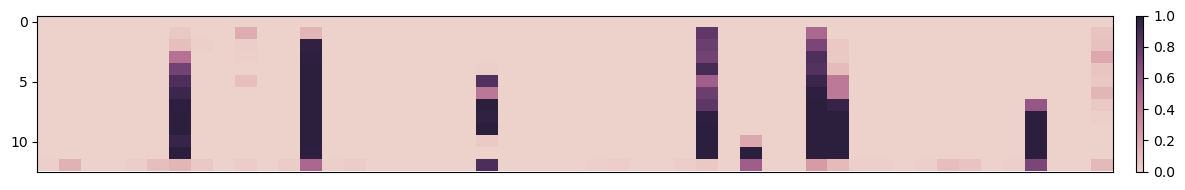

In [39]:
def plot_token_layer_heatmap(X, title, vmax=None):
    plt.figure(figsize=(12, 2))
    im = plt.imshow(X.T, aspect='auto', interpolation='nearest',
                    cmap=sns.cubehelix_palette(as_cmap=True), vmin=0, vmax=vmax)
    plt.colorbar(im, fraction=0.025, pad=0.02, label='') # Intermediate likelihood
    #plt.yticks(range(X.shape[1]), [f"L{l}" for l in range(X.shape[1])])
    plt.xticks([])
    plt.xlabel("") # Token position
    plt.title(title)
    plt.tight_layout()

vmax = np.percentile(np.concatenate([X_ai, X_human]), 99)
plot_token_layer_heatmap(X_ai,    "", vmax=vmax) # AI text: token × layer
plot_token_layer_heatmap(X_human, "", vmax=vmax) # Human text: token × layer


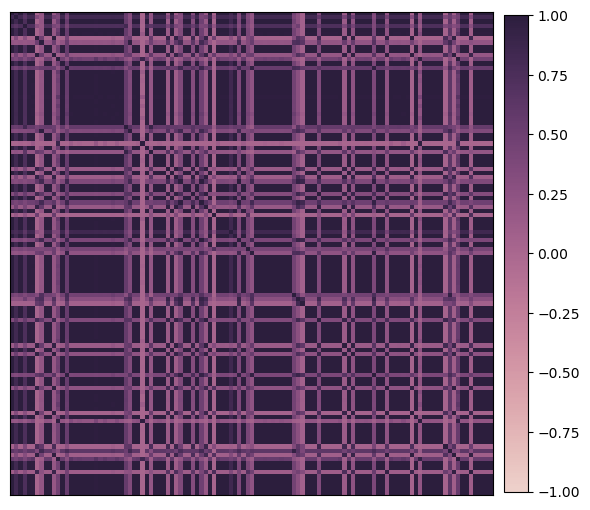

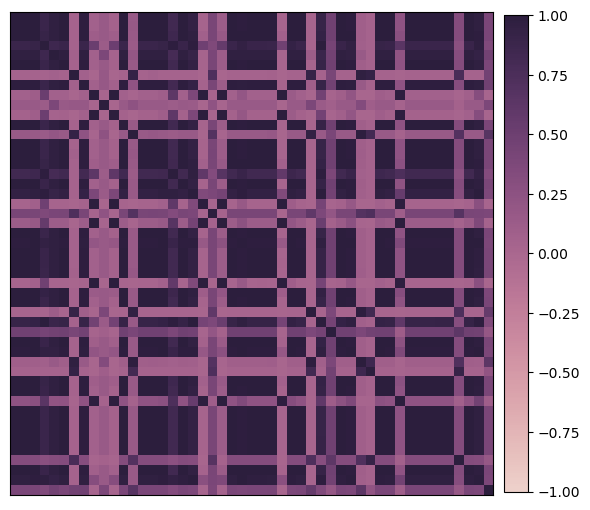

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

def recurrence(X):
    S = cosine_similarity(X)  # (seq, seq)
    np.fill_diagonal(S, 1.0)
    return S

S_ai = recurrence(X_ai)
S_h  = recurrence(X_human)

def show_recurrence(S, title):
    fig, ax = plt.subplots(figsize=(6,6), facecolor="white")
    im = ax.imshow(S, vmin=-1, vmax=1, cmap=sns.cubehelix_palette(as_cmap=True), interpolation="nearest")
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02, label="") # Cosine similarity
    plt.tight_layout()


show_recurrence(S_ai, "") # AI: token–token similarity
show_recurrence(S_h,  "") # Human: token–token similarity


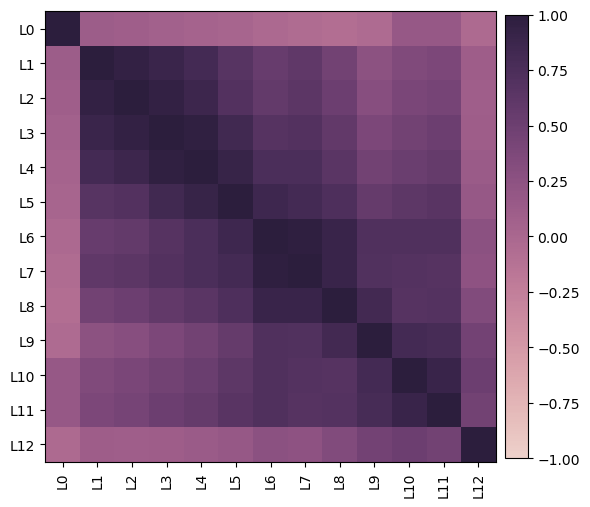

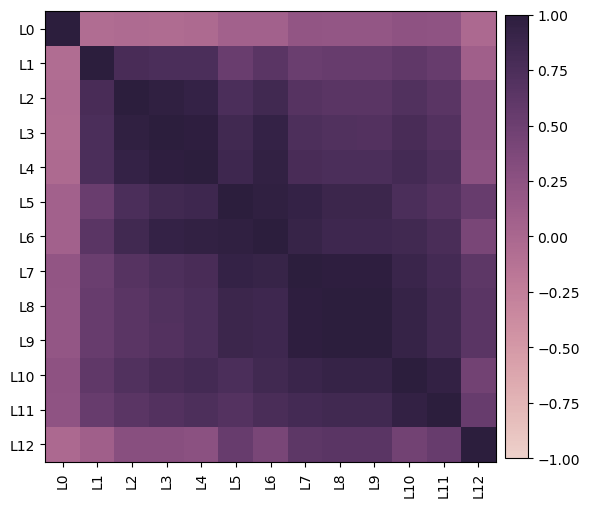

In [41]:
def layer_corr(X):
    return np.corrcoef(X, rowvar=False)

C_ai = layer_corr(X_ai)
C_h  = layer_corr(X_human)

def show_corr(C, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(C, vmin=-1, vmax=1, cmap=sns.cubehelix_palette(as_cmap=True), interpolation='nearest')
    plt.title(title)
    plt.xticks(range(C.shape[0]), [f"L{l}" for l in range(C.shape[0])], rotation=90)
    plt.yticks(range(C.shape[0]), [f"L{l}" for l in range(C.shape[0])])
    plt.colorbar(fraction=0.046, pad=0.02, label="") # Pearson r
    plt.tight_layout()

show_corr(C_ai, "") # AI: layer–layer correlation
show_corr(C_h,  "") # Human: layer–layer correlation


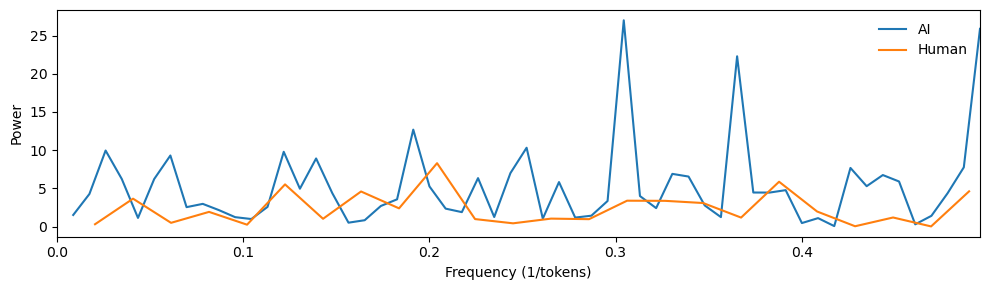

In [42]:
def token_agg_mean(X):
    return X.mean(axis=1)

def plot_fft(ai_signal, human_signal, out="trajectory_fft.png"):
    def power(x):
        x = (x - x.mean())
        P = np.abs(np.fft.rfft(x))**2
        f = np.fft.rfftfreq(len(x), d=1.0)
        return f[1:], P[1:] 

    f_ai, P_ai = power(ai_signal)
    f_h,  P_h  = power(human_signal)

    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(f_ai, P_ai, label="AI")
    ax.plot(f_h,  P_h,  label="Human")
    ax.set_xlabel("Frequency (1/tokens)")
    ax.set_ylabel("Power")
    ax.set_xlim(0, f_ai.max())
    ax.legend(frameon=False)
    fig.tight_layout(); fig.savefig(out, dpi=400, bbox_inches="tight")

plot_fft(token_agg_mean(X_ai), token_agg_mean(X_human))

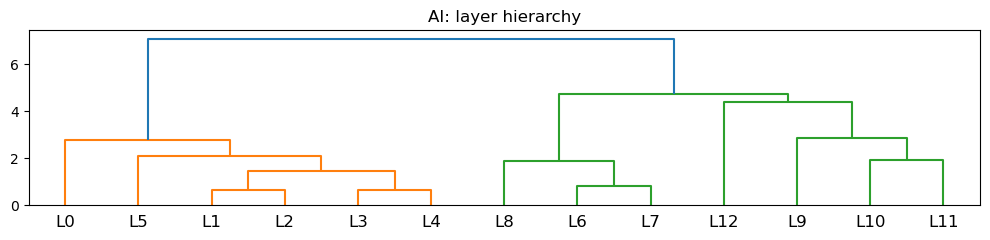

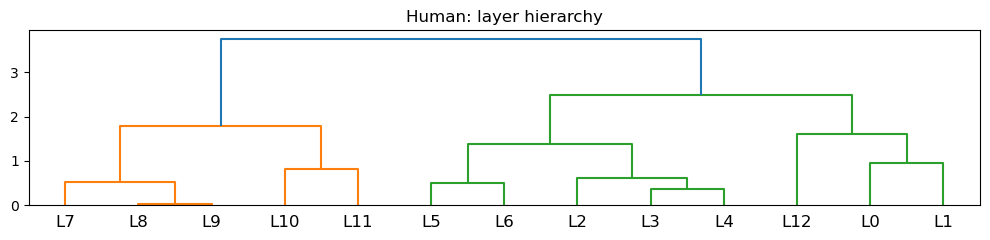

In [43]:
from scipy.cluster.hierarchy import linkage, dendrogram

def plot_layer_dendrogram(X, title, out="layer_dendrogram.png"):
    # cluster layers by their correlations across tokens
    Z = linkage(X.T, method="ward")  # shape (layers, layers)
    fig, ax = plt.subplots(figsize=(10,2.5))
    dendrogram(Z, labels=[f"L{i}" for i in range(X.shape[1])], ax=ax, leaf_rotation=0)
    ax.set_title(title)
    fig.tight_layout(); fig.savefig(out, dpi=400, bbox_inches="tight")

plot_layer_dendrogram(X_ai,    "AI: layer hierarchy",    out="dendro_ai.png")
plot_layer_dendrogram(X_human, "Human: layer hierarchy", out="dendro_human.png")
